# MPG regression problem

In [1]:
import sys
import os
import random
import csv
from pprint import pprint

module_path = os.path.abspath(os.path.join("..", ".."))
sys.path.append(module_path)

from perceptron import normalizer
from perceptron.model import Model, train, cross_validate
from perceptron.layer import Layer
from perceptron.activation import (
    Heavyside,
    Linear,
    Relu,
    LeakyRelu,
    Sigmoid,
    Tanh,
    Softmax,
)
from perceptron.data_util import transpose
from perceptron.metric import MAE, MSE

from examples.visualization_utils import histories_plot


In [2]:
%config InlineBackend.figure_formats = ['svg']


In [3]:
with open("auto-mpg.csv", "rt") as f:
    data = [
        [float(value) for value in features]
        for *features, _ in [line for line in csv.reader(f) if line and "?" not in line]
    ]

targets, *features = transpose(data)
targets = [[value] for value in targets]
features = transpose(features)

output_normalizer = normalizer.MinMax()
output_normalizer.adapt(targets)

normalized_targets = [output_normalizer(target) for target in targets]


# Optimizers with single layer model with MSE loss

Training gd[lr=0.001]: 100% |████████████████████████████████████████| 50/50, loss=16, mae=3.12, mse=16    


target=[17.0], prediction=[21.106565240367182]
target=[13.0], prediction=[14.776588700106778]
target=[28.0], prediction=[29.895902759334902]
target=[18.5], prediction=[20.39409129045089]
target=[13.0], prediction=[13.560271102008569]
target=[19.0], prediction=[28.3788773354363]
target=[24.3], prediction=[28.0584175752026]
target=[37.7], prediction=[35.41169851645014]
target=[46.6], prediction=[34.75496415328821]
target=[16.0], prediction=[15.675372865733772]


Training momentum[lr=0.001]: 100% |████████████████████████████████████████| 50/50, loss=11.2, mae=2.5, mse=11.2 


target=[17.0], prediction=[17.813030860405306]
target=[13.0], prediction=[11.783200263726439]
target=[28.0], prediction=[29.63019807091787]
target=[18.5], prediction=[19.31918303126376]
target=[13.0], prediction=[12.48299674196066]
target=[19.0], prediction=[23.49649524254997]
target=[24.3], prediction=[26.244759784518738]
target=[37.7], prediction=[34.42523598093041]
target=[46.6], prediction=[33.400403254943214]
target=[16.0], prediction=[14.605579793922272]


Training nesterov[lr=0.001]: 100% |████████████████████████████████████████| 50/50, loss=11.2, mae=2.5, mse=11.2 


target=[17.0], prediction=[17.79484037321206]
target=[13.0], prediction=[11.76680460870966]
target=[28.0], prediction=[29.626661066235567]
target=[18.5], prediction=[19.31099533214023]
target=[13.0], prediction=[12.472553423923216]
target=[19.0], prediction=[23.486189261369404]
target=[24.3], prediction=[26.244270207605148]
target=[37.7], prediction=[34.424021543071426]
target=[46.6], prediction=[33.39869521671971]
target=[16.0], prediction=[14.588380415567695]


Training adagrad[lr=1.0]: 100% |████████████████████████████████████████| 50/50, loss=22.2, mae=3.68, mse=22.2


target=[17.0], prediction=[22.68042612261503]
target=[13.0], prediction=[16.001837632291732]
target=[28.0], prediction=[28.63788113663872]
target=[18.5], prediction=[20.06238621320392]
target=[13.0], prediction=[14.217719985734956]
target=[19.0], prediction=[29.505904753155605]
target=[24.3], prediction=[27.333400173389244]
target=[37.7], prediction=[36.520650600374275]
target=[46.6], prediction=[35.97614169856242]
target=[16.0], prediction=[16.280801670089406]


Training rmsprop[lr=0.01]: 100% |████████████████████████████████████████| 50/50, loss=11.2, mae=2.52, mse=11.2


target=[17.0], prediction=[17.96588310844724]
target=[13.0], prediction=[11.501886467009854]
target=[28.0], prediction=[29.733649319468356]
target=[18.5], prediction=[19.091415927329894]
target=[13.0], prediction=[12.345626921328318]
target=[19.0], prediction=[23.677512884035192]
target=[24.3], prediction=[26.51342674087279]
target=[37.7], prediction=[34.53187325121266]
target=[46.6], prediction=[33.573482124874175]
target=[16.0], prediction=[14.39306604561985]


Training adam[lr=0.01]: 100% |████████████████████████████████████████| 50/50, loss=15.4, mae=3.08, mse=15.4


target=[17.0], prediction=[21.32826058899552]
target=[13.0], prediction=[14.001798649098179]
target=[28.0], prediction=[30.429290280408694]
target=[18.5], prediction=[20.110761416113746]
target=[13.0], prediction=[13.064208306605]
target=[19.0], prediction=[28.127862034090253]
target=[24.3], prediction=[28.485331226064982]
target=[37.7], prediction=[35.2620995093824]
target=[46.6], prediction=[34.64050866683154]
target=[16.0], prediction=[15.348185827189383]


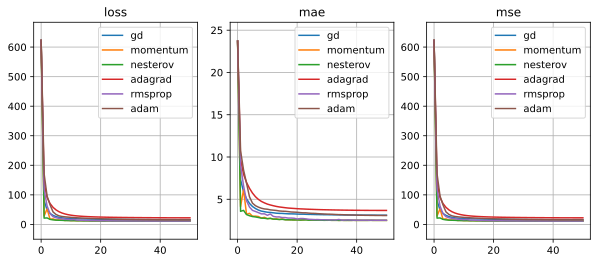

In [4]:
def model_factory():
    input_size = 7
    layer_init_method = "he"

    model = Model(normalizer="minmax")
    model.add(Layer(input_size, layer_size=1, init_method=layer_init_method))
    model.add(Linear())

    return model


runs_spec = (
    {"optimizer": "gd", "base_learning_rate": 0.001},
    {"optimizer": "momentum", "base_learning_rate": 0.001},
    {"optimizer": "nesterov", "base_learning_rate": 0.001},
    {"optimizer": "adagrad", "base_learning_rate": 1.0},
    {"optimizer": "rmsprop", "base_learning_rate": 0.01},
    {"optimizer": "adam", "base_learning_rate": 0.01},
)

epochs = 50
batch_size = 32
metrics = ["mse", "mae"]
histories = {}
for spec in runs_spec:
    random.seed(0)

    model = model_factory()
    model.compile(spec["optimizer"])

    history = train(
        model=model,
        training_inputs=features,
        training_targets=targets,
        epochs=epochs,
        loss_function="mse",
        batch_size=batch_size,
        base_learning_rate=min(1.0, spec["base_learning_rate"] * batch_size),
        learning_rate_decay="linear",
        metrics=metrics,
        session_name=f"{spec['optimizer']}[lr={spec['base_learning_rate']}]",
    )
    histories[spec["optimizer"]] = history

    # Sample predictions
    for index in random.choices(range(len(features)), k=10):
        target = targets[index]
        prediction = model.predict(features[index])
        print(f"{target=}, {prediction=}")

histories_plot(histories)


# Optimizers with single layer model with MAE loss

Training gd[lr=0.01]: 100% |████████████████████████████████████████| 50/50, loss=3.11, mae=3.11, mse=17  


target=[17.0], prediction=[20.399741052519154]
target=[13.0], prediction=[14.650434741977513]
target=[28.0], prediction=[28.35653178190166]
target=[18.5], prediction=[19.783887619810667]
target=[13.0], prediction=[13.530788893435524]
target=[19.0], prediction=[28.304945709740565]
target=[24.3], prediction=[26.82315789233857]
target=[37.7], prediction=[35.2591871939772]
target=[46.6], prediction=[34.72631073212781]
target=[16.0], prediction=[15.438086284530122]


Training momentum[lr=0.001]: 100% |████████████████████████████████████████| 50/50, loss=3.11, mae=3.11, mse=17.1


target=[17.0], prediction=[20.42767046658424]
target=[13.0], prediction=[14.683273358690021]
target=[28.0], prediction=[28.379530421864693]
target=[18.5], prediction=[19.80173614299388]
target=[13.0], prediction=[13.549287102126574]
target=[19.0], prediction=[28.342073126599928]
target=[24.3], prediction=[26.853831689924434]
target=[37.7], prediction=[35.27644793498523]
target=[46.6], prediction=[34.74345347583329]
target=[16.0], prediction=[15.45328741293511]


Training nesterov[lr=0.001]: 100% |████████████████████████████████████████| 50/50, loss=3.11, mae=3.11, mse=17  


target=[17.0], prediction=[20.419812744338564]
target=[13.0], prediction=[14.67638069626185]
target=[28.0], prediction=[28.37547188117241]
target=[18.5], prediction=[19.798516613395545]
target=[13.0], prediction=[13.545709791730909]
target=[19.0], prediction=[28.33353508675691]
target=[24.3], prediction=[26.847926623962742]
target=[37.7], prediction=[35.27201543000438]
target=[46.6], prediction=[34.73888127465446]
target=[16.0], prediction=[15.449881238750145]


Training adagrad[lr=1.0]: 100% |████████████████████████████████████████| 50/50, loss=3.34, mae=3.34, mse=19  


target=[17.0], prediction=[21.5167745803122]
target=[13.0], prediction=[14.893673348172136]
target=[28.0], prediction=[28.47584871282209]
target=[18.5], prediction=[19.70346929710844]
target=[13.0], prediction=[13.521699135938473]
target=[19.0], prediction=[28.717368443747922]
target=[24.3], prediction=[27.10331214417966]
target=[37.7], prediction=[35.49314543718012]
target=[46.6], prediction=[34.994186338893215]
target=[16.0], prediction=[15.56054689818093]


Training rmsprop[lr=0.01]: 100% |████████████████████████████████████████| 50/50, loss=2.48, mae=2.48, mse=11.9


target=[17.0], prediction=[17.28559456361231]
target=[13.0], prediction=[12.104895340715519]
target=[28.0], prediction=[28.30364135738933]
target=[18.5], prediction=[18.878918050810253]
target=[13.0], prediction=[12.937392551532344]
target=[19.0], prediction=[23.770709881523466]
target=[24.3], prediction=[25.41874274501344]
target=[37.7], prediction=[34.050494521721795]
target=[46.6], prediction=[33.21129923576892]
target=[16.0], prediction=[14.662662846060945]


Training adam[lr=0.01]: 100% |████████████████████████████████████████| 50/50, loss=2.56, mae=2.56, mse=12.5


target=[17.0], prediction=[18.010826753551335]
target=[13.0], prediction=[12.53218719716757]
target=[28.0], prediction=[28.390399983596907]
target=[18.5], prediction=[19.009304972446056]
target=[13.0], prediction=[13.01133361304334]
target=[19.0], prediction=[25.02424821464667]
target=[24.3], prediction=[25.92791532287464]
target=[37.7], prediction=[34.13993120376027]
target=[46.6], prediction=[33.449958515369346]
target=[16.0], prediction=[14.771705346324975]


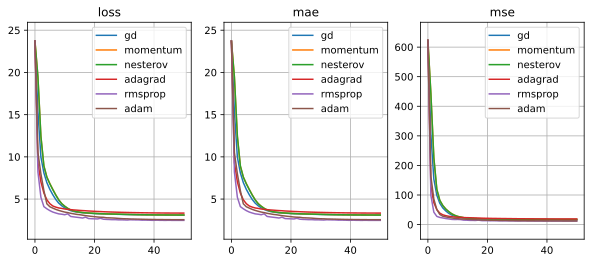

In [5]:
def model_factory():
    input_size = 7
    layer_init_method = "he"

    model = Model(normalizer="minmax")
    model.add(Layer(input_size, layer_size=1, init_method=layer_init_method))
    model.add(Linear())

    return model


runs_spec = (
    # GD needs higher LR for MAE loss
    {"optimizer": "gd", "base_learning_rate": 0.01},
    {"optimizer": "momentum", "base_learning_rate": 0.001},
    {"optimizer": "nesterov", "base_learning_rate": 0.001},
    {"optimizer": "adagrad", "base_learning_rate": 1.0},
    {"optimizer": "rmsprop", "base_learning_rate": 0.01},
    {"optimizer": "adam", "base_learning_rate": 0.01},
)

epochs = 50
batch_size = 32
metrics = ["mse", "mae"]
histories = {}
for spec in runs_spec:
    random.seed(0)

    model = model_factory()
    model.compile(spec["optimizer"])

    history = train(
        model=model,
        training_inputs=features,
        training_targets=targets,
        epochs=epochs,
        loss_function="mae",
        batch_size=batch_size,
        base_learning_rate=min(1.0, spec["base_learning_rate"] * batch_size),
        learning_rate_decay="linear",
        metrics=metrics,
        session_name=f"{spec['optimizer']}[lr={spec['base_learning_rate']}]",
    )
    histories[spec["optimizer"]] = history

    # Sample predictions
    for index in random.choices(range(len(features)), k=10):
        target = targets[index]
        prediction = model.predict(features[index])
        print(f"{target=}, {prediction=}")

histories_plot(histories)


# Multi layer model

Training: 100% |████████████████████████████████████████| 20/20, loss=2.06, mae=2.06, mse=9.3 


target=[28.0], prediction=[26.379782509290482]
target=[20.0], prediction=[18.029072249001803]
target=[19.0], prediction=[19.52124683124008]
target=[16.0], prediction=[14.809339263500302]
target=[19.1], prediction=[21.615909999260666]
target=[36.4], prediction=[25.917548206500776]
target=[19.2], prediction=[18.406168927576644]
target=[20.2], prediction=[17.672050973092194]
target=[34.1], prediction=[33.23522315126434]
target=[18.0], prediction=[16.388247691131603]


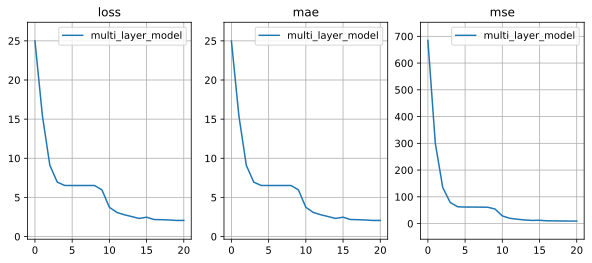

In [6]:
random.seed(0)


def model_factory():
    input_size = 7
    layer_init_method = "he"

    model = Model(normalizer="minmax")
    model.add(Layer(input_size, layer_size=15, init_method=layer_init_method))
    model.add(Sigmoid())
    model.add(Layer(input_size=15, layer_size=5, init_method=layer_init_method))
    model.add(Sigmoid())
    model.add(Layer(input_size=5, layer_size=1, init_method=layer_init_method))
    model.add(Linear())

    return model


epochs = 20
batch_size = 4
optimizer = "adam"
metrics = ["mse", "mae"]
training_params = dict(
    training_inputs=features,
    training_targets=targets,
    epochs=epochs,
    loss_function="mae",
    batch_size=batch_size,
    base_learning_rate=0.01 * batch_size,
    learning_rate_decay="linear",
    metrics=metrics,
)

model = model_factory()
model.compile(optimizer)
history = train(model, **training_params)

# Sample predictions
for index in random.choices(range(len(features)), k=10):
    target = targets[index]
    prediction = model.predict(features[index])
    print(f"{target=}, {prediction=}")

histories_plot({"multi_layer_model": history})


# Multi layer model with output normalization

Training: 100% |████████████████████████████████████████| 20/20, loss=0.0511, mae=0.0511, mse=0.00531


denormalized_mae = 1.922333802804333
denormalized_mse = 7.5077063474647625
target =  0.50532, prediction =  0.50579, denormalized_target = 28.0, denormalized_prediction = 28.01764
target =  0.29255, prediction =  0.32953, denormalized_target = 20.0, denormalized_prediction = 21.39027
target =  0.26596, prediction =  0.29916, denormalized_target = 19.0, denormalized_prediction = 20.24859
target =  0.18617, prediction =  0.15637, denormalized_target = 16.0, denormalized_prediction = 14.87961
target =  0.26862, prediction =    0.337, denormalized_target = 19.1, denormalized_prediction = 21.67115
target =  0.72872, prediction =   0.4942, denormalized_target = 36.4, denormalized_prediction = 27.58177
target =  0.27128, prediction =  0.27004, denormalized_target = 19.2, denormalized_prediction = 19.15349
target =  0.29787, prediction =  0.23664, denormalized_target = 20.2, denormalized_prediction = 17.89784
target =  0.66755, prediction =  0.71856, denormalized_target = 34.1, denormalized_pr

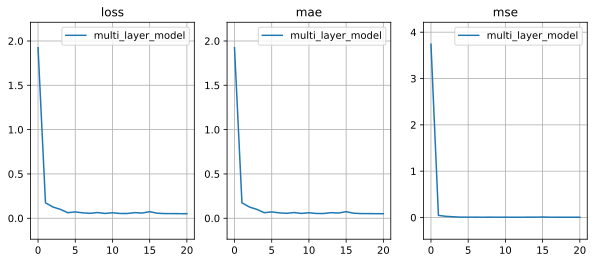

In [7]:
random.seed(0)

training_params["training_targets"] = normalized_targets

model = model_factory()
model.compile(optimizer)
history = train(model, **training_params)

# Calculate MAE and MSE for denormalized output
denormalized_predictions = [
    output_normalizer(prediction, inverse=True)
    for prediction in [model.predict(sample) for sample in features]
]
denormalized_mae = MAE().calculate_avg(denormalized_predictions, targets)
denormalized_mse = MSE().calculate_avg(denormalized_predictions, targets)
print(f"{denormalized_mae = }")
print(f"{denormalized_mse = }")

# Sample predictions with denormalized values
for index in random.choices(range(len(features)), k=10):
    target = normalized_targets[index]
    denormalized_target = output_normalizer(target, inverse=True)

    prediction = model.predict(features[index])
    denormalized_prediction = output_normalizer(prediction, inverse=True)

    print(
        f"target ={round(target[0], 5):9}, "
        f"prediction ={round(prediction[0], 5):9}, "
        f"denormalized_target ={round(denormalized_target[0], 5):5}, "
        f"denormalized_prediction ={round(denormalized_prediction[0], 5):9}"
    )

histories_plot({"multi_layer_model": history})


# Cross validating multi layer model with output normalization

Training: 100% |████████████████████████████████████████| 20/20, loss=0.0533, mae=0.0533, mse=0.00534, val_loss=0.0546, val_mae=0.0546, val_mse=0.00641
Training: 100% |████████████████████████████████████████| 20/20, loss=0.0514, mae=0.0514, mse=0.00559, val_loss=0.056, val_mae=0.056, val_mse=0.00573  
Training: 100% |████████████████████████████████████████| 20/20, loss=0.0539, mae=0.0539, mse=0.0059, val_loss=0.0503, val_mae=0.0503, val_mse=0.00484 


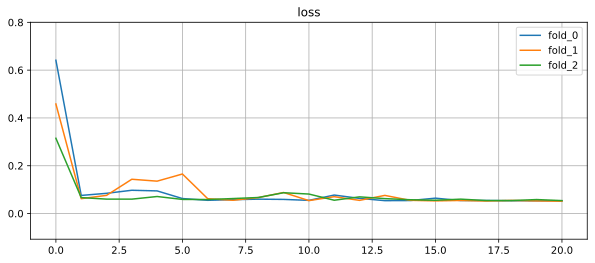

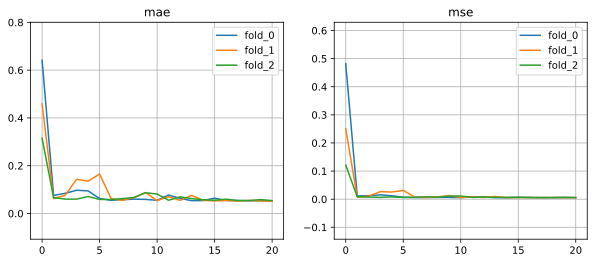

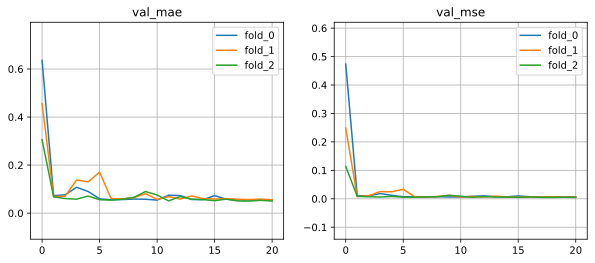

In [8]:
random.seed(0)

if training_params.get("inputs") is None:
    training_params["inputs"] = training_params.pop("training_inputs")
if training_params.get("targets") is None:
    training_params["targets"] = training_params.pop("training_targets")
metrics = training_params["metrics"]

histories = cross_validate(
    model_factory=model_factory, fold_count=3, optimizer=optimizer, **training_params
)

histories_plot(histories, names=["loss"])
histories_plot(histories, names=["mae", "mse"])
histories_plot(histories, names=["val_mae", "val_mse"])
